In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
path_meta = './macho/MACHO/MACHO_dataset.dat'
path_light_Curves = './macho/MACHO/'


metadata = pd.read_csv(path_meta)
metadata = metadata[metadata.N>10]
metadata.head()

,Unnamed: 0,Class,N,Path,Band
0,0,RRL,1143,LCs/lc_1_3808_1671_B_mjd.dat,B
1,1,RRL,1135,LCs/lc_1_4167_1280_B_mjd.dat,B
2,2,RRL,1089,LCs/lc_2_5752_376_B_mjd.dat,B
3,3,RRL,1108,LCs/lc_2_5146_1297_B_mjd.dat,B
4,4,RRL,1021,LCs/lc_2_5873_895_B_mjd.dat,B


In [3]:
classes, amount = np.unique(metadata.Class, return_counts=True)

<BarContainer object of 7 artists>

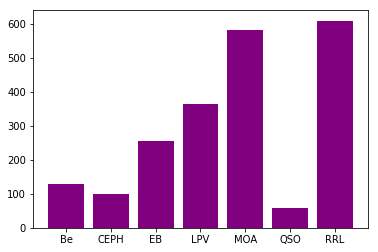

In [4]:
plt.bar(classes, amount, color='purple')

In [5]:
def plot_lc(mjd, mag, errmag, N, label):
    plt.clf()
    plt.title(label)
    plt.errorbar(mjd[:N], mag[:N], yerr=errmag[:N], color='k', ecolor='r')
    plt.grid(True)
    plt.show()

In [6]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


class MACHOLoader(object):
    def __init__(self, data, lenght):
        """ 
        Preprocessing the data for creating the dataloader
        """
        self.data = data
        self.lenght = lenght

    def __len__(self):
        """
        Number of images in the object dataset.
        """
        return self.data.shape[0]

    def __getitem__(self, index):
        """
        Return an item from the dataset.
        """
        x = np.zeros((3, self.lenght))
        light_curve = pd.read_csv(path_light_Curves + self.data.Path[index], skiprows=2, 
                                  delim_whitespace=False, names=['mjd', 'mag', 'errmag'])
        light_curve = light_curve.values.T
        light_curve = self.normalize_n2(light_curve)
        x[:,:light_curve.shape[1]] = light_curve
        
        y = self.data.Class[index]
        return np.float32(x).T, np.int(y), light_curve.shape[1]

    def normalize_n1(self, light_curve):
        """ 
        Normalizing the data feature by feature.
        """
        for i, feature in enumerate(light_curve):
            min_ = np.min(feature)
            max_ = np.max(feature)
            light_curve[i,:] = (light_curve[i,:] - min_) / (max_ - min_)
        return light_curve
    
    def normalize_n2(self, light_curve):
        """ 
        Normalizing the data feature by feature.
        """
        for i, feature in enumerate(light_curve):
            mean_ = np.mean(feature)
            std_ = np.std(feature)
            light_curve[i,:] = (light_curve[i,:] - mean_) / std_
        return light_curve
        
        

def get_MACHO_loaders(metadata, batch_size, mode='train'):
    """Build and return data loader."""
    
    class_dict = {class_:i for i, class_ in enumerate(np.unique(metadata.Class))}
    metadata = metadata.replace({'Class': class_dict})
    
    
    lc_data_train, lc_data_test = train_test_split(metadata, test_size=0.5)
    data_train = MACHOLoader(lc_data_train.reset_index(), np.max(metadata.N))
    
    lc_data_val, lc_data_test = train_test_split(lc_data_test, test_size=0.4)
    data_val = MACHOLoader(lc_data_val.reset_index(), np.max(metadata.N))
    data_test = MACHOLoader(lc_data_test.reset_index(), np.max(metadata.N))
    
    class_sample_count = np.unique(lc_data_train.Class, return_counts=True)[1]
    weights = 1. / torch.Tensor(class_sample_count)
    samples_weight = np.array([weights[t] for t in lc_data_train.Class])
    samples_weight = torch.from_numpy(samples_weight)
    sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), 
                                                             len(samples_weight))
    data_loader_train = DataLoader(dataset=data_train,
                             batch_size=batch_size, sampler=sampler, drop_last=False)
        
    data_loader_val = DataLoader(dataset=data_val,
                                 batch_size=batch_size,
                                 shuffle=False, drop_last=False)
    
    data_loader_test = DataLoader(dataset=data_test,
                                  batch_size=batch_size,
                                  shuffle=False, drop_last=False)
    return data_loader_train, data_loader_val, data_loader_test, class_dict


In [7]:
batch_size = 64
dataloader_train, dataloader_val, dataloader_test, class_dict = get_MACHO_loaders(metadata, batch_size)
inv_class_dict = {i:class_ for i, class_ in enumerate(class_dict.keys())}
some_lcs = iter(dataloader_train).next()

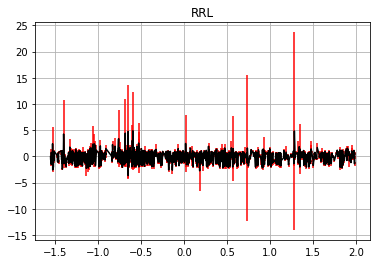

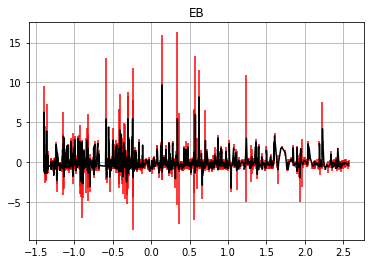

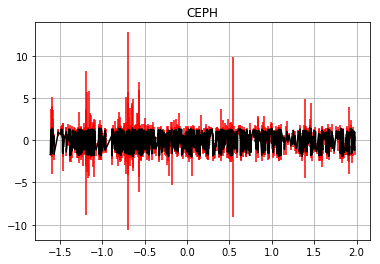

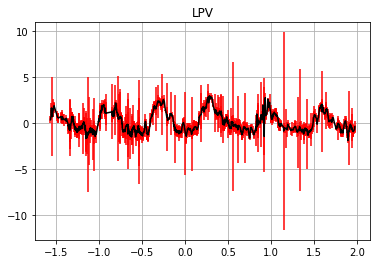

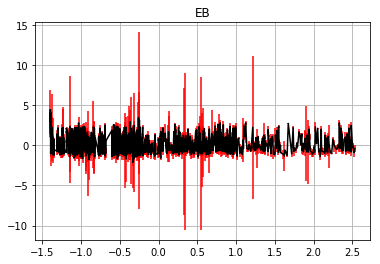

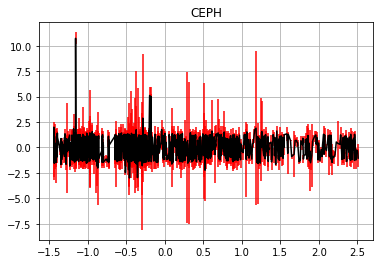

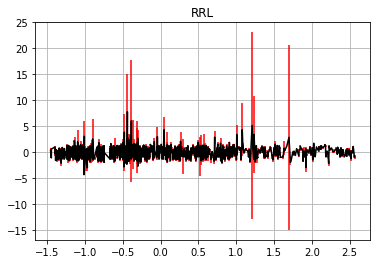

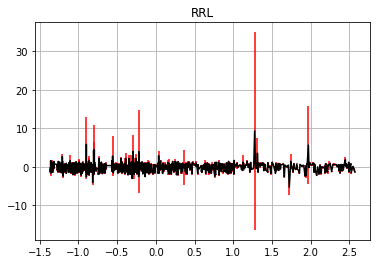

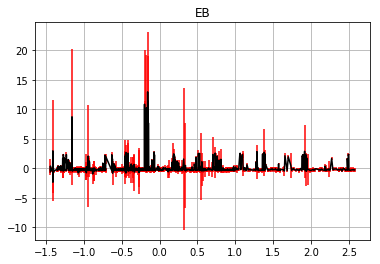

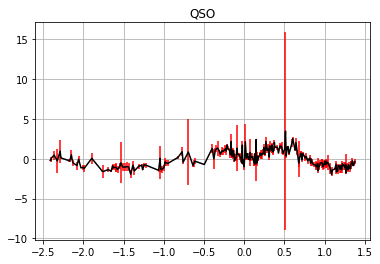

In [8]:
for i, lc in enumerate(some_lcs[0][:10]):
    label = inv_class_dict[some_lcs[1][i].item()]
    plot_lc(lc[:,0].numpy(), lc[:,1].numpy(), lc[:,2].numpy(), some_lcs[2][i], label)

In [9]:
import torch.nn as nn

class LightCurveNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, batch_size, drop_prob):
        super(LightCurveNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.softmax = nn.Softmax()
        
    def forward(self, x):
        x = x.float()
        lstm_out, (h_t, c_t) = self.lstm(x)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(lstm_out)
        out = self.softmax(out)
        return out, h_t
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.n_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.n_layers, self.batch_size, self.hidden_dim))


In [10]:
class EarlyStopping:
    def __init__(self, patience):
        """Class for determining the stopping criterion for the model"""
        self.patience = patience
        self.counter = 0
        self.best_metric = 0

    def count(self, metric, model):
        is_best = bool( metric >= self.best_metric)
        self.best_metric = max(metric, self.best_metric)
        if is_best:
            self.counter = 0
            self.save_weights(model)
            print('Weights saved.')
        else:
            self.counter += 1
        if self.counter >= self.patience:
            return True
        else:
            return False

    def save_weights(self, model):
        """Save Autoencoder weights."""
        torch.save(model.state_dict(), 'weights/model_parameters.pth')

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
input_size = 3
output_size = len(class_dict.keys())
hidden_dim = 256
n_layers = 2 
drop_prob = 0.5

In [12]:
model = LightCurveNet(input_size, output_size, hidden_dim, n_layers, batch_size, drop_prob)
model.to(device)

lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
nb_epochs = 2000
patience = 50
es = EarlyStopping(patience)

In [13]:
def generate_mask(sq_lenght, max_lenght):
    mask = []
    step = 0
    ix = 0
    while step < len(sq_lenght)*max_lenght:
        mask.extend([True]*(sq_lenght[ix].item()-1))
        mask.extend([False]*(max_lenght-sq_lenght[ix].item()+1))
        ix+=1
        step+=max_lenght
    return mask

In [14]:
from sklearn.metrics import f1_score


def test(model, dataloader, epoch, nb_epochs):
    model.eval()
    total_loss=0
    total_f1=0
    with torch.no_grad():
        for inputs, labels, sq_lenght in dataloader:
            inputs, labels = inputs.to(device).float(), labels.to(device).long()
            output, _ = model(inputs)
            mask = generate_mask(sq_lenght, int(np.max(metadata.N)))
            val_loss = criterion(output[mask], labels.repeat_interleave((sq_lenght-1).to(device)))
            total_loss+=val_loss.item()
            last_valid_output = output[[sq_lenght[i].item()+(i*int(np.max(metadata.N)))-1 for i in range(len(sq_lenght))]]
            total_f1+=f1_score(labels.cpu().numpy(),
                                      np.argmax(last_valid_output.cpu().detach().numpy(), axis=1), average='macro')
            
    loss = total_loss/len(dataloader)
    f1 = total_f1/len(dataloader)
    print("Epoch: {}/{}...".format(epoch+1, nb_epochs),
          "Loss val: {:.3f}...".format(loss),
          "F1-score val: {:.2f}%...".format(f1*100),
         )
    stop = es.count(f1, model)
    stop=False
    return stop, loss, f1   



for epoch in range(nb_epochs):
    model.train()
    total_loss, total_loss_val = 0, 0
    total_f1, total_f1_val = 0, 0
    for inputs, labels, sq_lenght in dataloader_train:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        model.zero_grad()
        output, _ = model(inputs)
        mask = generate_mask(sq_lenght, int(np.max(metadata.N)))
        loss = criterion(output[mask], labels.repeat_interleave((sq_lenght-1).to(device)))
        loss.backward()
        optimizer.step()
        total_loss+=loss.item()
        last_valid_output = output[[sq_lenght[i].item()+(i*int(np.max(metadata.N)))-1 for i in range(len(sq_lenght))]]
        total_f1+=f1_score(labels.cpu().numpy(), 
                           np.argmax(last_valid_output.cpu().detach().numpy(), axis=1), average='macro')
    
    print("Epoch: {}/{}...".format(epoch+1, nb_epochs),
          "Loss train: {:.3f}...".format(total_loss/len(dataloader_train)),
          "F1-score train: {:.2f}%...".format(total_f1/len(dataloader_train)*100),
         )
    
    stop, loss_val, f1_val = test(model, dataloader_val, epoch, nb_epochs)
    if stop:
        break

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 1/2000... Loss train: 1.937... F1-score train: 4.28%...
Epoch: 1/2000... Loss val: 2.004... F1-score val: 1.24%...
Weights saved.
Epoch: 2/2000... Loss train: 1.929... F1-score train: 6.63%...
Epoch: 2/2000... Loss val: 1.871... F1-score val: 9.10%...
Weights saved.
Epoch: 3/2000... Loss train: 1.922... F1-score train: 5.05%...
Epoch: 3/2000... Loss val: 1.949... F1-score val: 3.41%...
Epoch: 4/2000... Loss train: 1.934... F1-score train: 3.32%...
Epoch: 4/2000... Loss val: 1.936... F1-score val: 1.24%...
Epoch: 5/2000... Loss train: 1.929... F1-score train: 3.67%...
Epoch: 5/2000... Loss val: 1.924... F1-score val: 4.70%...
Epoch: 6/2000... Loss train: 1.927... F1-score train: 3.80%...
Epoch: 6/2000... Loss val: 1.944... F1-score val: 1.24%...
Epoch: 7/2000... Loss train: 1.933... F1-score train: 3.51%...
Epoch: 7/2000... Loss val: 1.924... F1-score val: 5.77%...
Epoch: 8/2000... Loss train: 1.937... F1-score train: 3.32%...
Epoch: 8/2000... Loss val: 1.949... F1-score val: 1.2

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Epoch: 45/2000... Loss train: 1.763... F1-score train: 31.00%...
Epoch: 45/2000... Loss val: 1.788... F1-score val: 25.68%...
Epoch: 46/2000... Loss train: 1.783... F1-score train: 30.40%...
Epoch: 46/2000... Loss val: 1.767... F1-score val: 26.34%...
Epoch: 47/2000... Loss train: 1.744... F1-score train: 31.03%...
Epoch: 47/2000... Loss val: 1.799... F1-score val: 25.38%...
Epoch: 48/2000... Loss train: 1.774... F1-score train: 28.42%...
Epoch: 48/2000... Loss val: 1.784... F1-score val: 24.32%...
Epoch: 49/2000... Loss train: 1.763... F1-score train: 34.23%...
Epoch: 49/2000... Loss val: 1.729... F1-score val: 30.98%...
Weights saved.
Epoch: 50/2000... Loss train: 1.749... F1-score train: 31.64%...
Epoch: 50/2000... Loss val: 1.760... F1-score val: 28.25%...
Epoch: 51/2000... Loss train: 1.744... F1-score train: 34.67%...
Epoch: 51/2000... Loss val: 1.727... F1-score val: 32.54%...
Weights saved.
Epoch: 52/2000... Loss train: 1.751... F1-score train: 33.68%...
Epoch: 52/2000... Loss 

Epoch: 109/2000... Loss val: 1.675... F1-score val: 36.27%...
Epoch: 110/2000... Loss train: 1.592... F1-score train: 48.03%...
Epoch: 110/2000... Loss val: 1.669... F1-score val: 33.92%...
Epoch: 111/2000... Loss train: 1.589... F1-score train: 48.62%...
Epoch: 111/2000... Loss val: 1.678... F1-score val: 34.16%...
Epoch: 112/2000... Loss train: 1.567... F1-score train: 50.18%...
Epoch: 112/2000... Loss val: 1.655... F1-score val: 36.04%...
Epoch: 113/2000... Loss train: 1.568... F1-score train: 50.14%...
Epoch: 113/2000... Loss val: 1.680... F1-score val: 34.06%...
Epoch: 114/2000... Loss train: 1.566... F1-score train: 50.71%...
Epoch: 114/2000... Loss val: 1.674... F1-score val: 35.87%...
Epoch: 115/2000... Loss train: 1.556... F1-score train: 51.67%...
Epoch: 115/2000... Loss val: 1.670... F1-score val: 36.06%...
Epoch: 116/2000... Loss train: 1.535... F1-score train: 52.62%...
Epoch: 116/2000... Loss val: 1.676... F1-score val: 34.80%...
Epoch: 117/2000... Loss train: 1.546... F1

Epoch: 173/2000... Loss train: 1.423... F1-score train: 64.65%...
Epoch: 173/2000... Loss val: 1.603... F1-score val: 41.56%...
Epoch: 174/2000... Loss train: 1.436... F1-score train: 63.44%...
Epoch: 174/2000... Loss val: 1.612... F1-score val: 41.18%...
Epoch: 175/2000... Loss train: 1.448... F1-score train: 61.67%...
Epoch: 175/2000... Loss val: 1.621... F1-score val: 38.55%...
Epoch: 176/2000... Loss train: 1.456... F1-score train: 59.79%...
Epoch: 176/2000... Loss val: 1.612... F1-score val: 41.21%...
Epoch: 177/2000... Loss train: 1.462... F1-score train: 60.80%...
Epoch: 177/2000... Loss val: 1.617... F1-score val: 40.31%...
Epoch: 178/2000... Loss train: 1.421... F1-score train: 64.48%...
Epoch: 178/2000... Loss val: 1.617... F1-score val: 40.70%...
Epoch: 179/2000... Loss train: 1.467... F1-score train: 59.50%...
Epoch: 179/2000... Loss val: 1.595... F1-score val: 41.78%...
Epoch: 180/2000... Loss train: 1.428... F1-score train: 62.82%...
Epoch: 180/2000... Loss val: 1.597... 

Epoch: 237/2000... Loss train: 1.309... F1-score train: 82.78%...
Epoch: 237/2000... Loss val: 1.609... F1-score val: 42.15%...
Epoch: 238/2000... Loss train: 1.321... F1-score train: 82.04%...
Epoch: 238/2000... Loss val: 1.600... F1-score val: 44.71%...
Epoch: 239/2000... Loss train: 1.310... F1-score train: 83.02%...
Epoch: 239/2000... Loss val: 1.592... F1-score val: 44.28%...
Epoch: 240/2000... Loss train: 1.324... F1-score train: 81.00%...
Epoch: 240/2000... Loss val: 1.606... F1-score val: 43.64%...
Epoch: 241/2000... Loss train: 1.335... F1-score train: 79.84%...
Epoch: 241/2000... Loss val: 1.584... F1-score val: 45.08%...
Epoch: 242/2000... Loss train: 1.353... F1-score train: 79.29%...
Epoch: 242/2000... Loss val: 1.585... F1-score val: 44.40%...
Epoch: 243/2000... Loss train: 1.327... F1-score train: 81.61%...
Epoch: 243/2000... Loss val: 1.594... F1-score val: 42.92%...
Epoch: 244/2000... Loss train: 1.344... F1-score train: 80.42%...
Epoch: 244/2000... Loss val: 1.585... 

Epoch: 300/2000... Loss val: 1.592... F1-score val: 44.74%...
Epoch: 301/2000... Loss train: 1.277... F1-score train: 86.10%...
Epoch: 301/2000... Loss val: 1.598... F1-score val: 46.10%...
Epoch: 302/2000... Loss train: 1.285... F1-score train: 86.38%...
Epoch: 302/2000... Loss val: 1.596... F1-score val: 43.91%...
Epoch: 303/2000... Loss train: 1.284... F1-score train: 86.36%...
Epoch: 303/2000... Loss val: 1.591... F1-score val: 45.53%...
Epoch: 304/2000... Loss train: 1.272... F1-score train: 86.69%...
Epoch: 304/2000... Loss val: 1.603... F1-score val: 45.49%...
Epoch: 305/2000... Loss train: 1.268... F1-score train: 88.09%...
Epoch: 305/2000... Loss val: 1.584... F1-score val: 47.66%...
Epoch: 306/2000... Loss train: 1.268... F1-score train: 87.58%...
Epoch: 306/2000... Loss val: 1.592... F1-score val: 46.52%...
Epoch: 307/2000... Loss train: 1.275... F1-score train: 88.35%...
Epoch: 307/2000... Loss val: 1.596... F1-score val: 46.41%...
Epoch: 308/2000... Loss train: 1.268... F1

Epoch: 365/2000... Loss train: 1.273... F1-score train: 88.99%...
Epoch: 365/2000... Loss val: 1.592... F1-score val: 44.47%...
Epoch: 366/2000... Loss train: 1.278... F1-score train: 87.63%...
Epoch: 366/2000... Loss val: 1.570... F1-score val: 46.34%...
Epoch: 367/2000... Loss train: 1.252... F1-score train: 88.97%...
Epoch: 367/2000... Loss val: 1.587... F1-score val: 45.02%...
Epoch: 368/2000... Loss train: 1.252... F1-score train: 89.01%...
Epoch: 368/2000... Loss val: 1.581... F1-score val: 44.11%...
Epoch: 369/2000... Loss train: 1.259... F1-score train: 87.12%...
Epoch: 369/2000... Loss val: 1.555... F1-score val: 45.26%...
Epoch: 370/2000... Loss train: 1.271... F1-score train: 87.94%...
Epoch: 370/2000... Loss val: 1.572... F1-score val: 47.35%...
Epoch: 371/2000... Loss train: 1.258... F1-score train: 88.21%...
Epoch: 371/2000... Loss val: 1.574... F1-score val: 46.54%...
Epoch: 372/2000... Loss train: 1.251... F1-score train: 89.68%...
Epoch: 372/2000... Loss val: 1.554... 

Epoch: 429/2000... Loss train: 1.244... F1-score train: 91.53%...
Epoch: 429/2000... Loss val: 1.579... F1-score val: 45.94%...
Epoch: 430/2000... Loss train: 1.246... F1-score train: 90.60%...
Epoch: 430/2000... Loss val: 1.570... F1-score val: 47.37%...
Epoch: 431/2000... Loss train: 1.255... F1-score train: 89.87%...
Epoch: 431/2000... Loss val: 1.590... F1-score val: 44.35%...
Epoch: 432/2000... Loss train: 1.239... F1-score train: 91.58%...
Epoch: 432/2000... Loss val: 1.573... F1-score val: 48.20%...
Epoch: 433/2000... Loss train: 1.245... F1-score train: 90.80%...
Epoch: 433/2000... Loss val: 1.579... F1-score val: 44.33%...
Epoch: 434/2000... Loss train: 1.249... F1-score train: 89.83%...
Epoch: 434/2000... Loss val: 1.578... F1-score val: 45.70%...
Epoch: 435/2000... Loss train: 1.238... F1-score train: 91.48%...
Epoch: 435/2000... Loss val: 1.580... F1-score val: 46.48%...
Epoch: 436/2000... Loss train: 1.231... F1-score train: 92.62%...
Epoch: 436/2000... Loss val: 1.552... 

Epoch: 493/2000... Loss val: 1.568... F1-score val: 48.18%...
Epoch: 494/2000... Loss train: 1.215... F1-score train: 94.32%...
Epoch: 494/2000... Loss val: 1.584... F1-score val: 44.73%...
Epoch: 495/2000... Loss train: 1.235... F1-score train: 92.36%...
Epoch: 495/2000... Loss val: 1.565... F1-score val: 46.01%...
Epoch: 496/2000... Loss train: 1.247... F1-score train: 90.29%...
Epoch: 496/2000... Loss val: 1.597... F1-score val: 45.50%...
Epoch: 497/2000... Loss train: 1.228... F1-score train: 92.90%...
Epoch: 497/2000... Loss val: 1.559... F1-score val: 48.30%...
Epoch: 498/2000... Loss train: 1.246... F1-score train: 90.13%...
Epoch: 498/2000... Loss val: 1.605... F1-score val: 43.56%...
Epoch: 499/2000... Loss train: 1.251... F1-score train: 90.79%...
Epoch: 499/2000... Loss val: 1.583... F1-score val: 45.75%...
Epoch: 500/2000... Loss train: 1.242... F1-score train: 90.83%...
Epoch: 500/2000... Loss val: 1.581... F1-score val: 47.52%...
Epoch: 501/2000... Loss train: 1.236... F1

Epoch: 558/2000... Loss train: 1.228... F1-score train: 91.89%...
Epoch: 558/2000... Loss val: 1.557... F1-score val: 48.00%...
Epoch: 559/2000... Loss train: 1.235... F1-score train: 91.74%...
Epoch: 559/2000... Loss val: 1.558... F1-score val: 47.63%...
Epoch: 560/2000... Loss train: 1.222... F1-score train: 92.38%...
Epoch: 560/2000... Loss val: 1.556... F1-score val: 47.06%...
Epoch: 561/2000... Loss train: 1.223... F1-score train: 93.21%...
Epoch: 561/2000... Loss val: 1.562... F1-score val: 47.86%...
Epoch: 562/2000... Loss train: 1.230... F1-score train: 92.55%...
Epoch: 562/2000... Loss val: 1.570... F1-score val: 47.18%...
Epoch: 563/2000... Loss train: 1.231... F1-score train: 91.28%...
Epoch: 563/2000... Loss val: 1.563... F1-score val: 48.25%...
Epoch: 564/2000... Loss train: 1.242... F1-score train: 90.54%...
Epoch: 564/2000... Loss val: 1.572... F1-score val: 46.68%...
Epoch: 565/2000... Loss train: 1.240... F1-score train: 91.59%...
Epoch: 565/2000... Loss val: 1.574... 

Epoch: 622/2000... Loss val: 1.562... F1-score val: 45.40%...
Epoch: 623/2000... Loss train: 1.225... F1-score train: 93.57%...
Epoch: 623/2000... Loss val: 1.565... F1-score val: 47.61%...
Epoch: 624/2000... Loss train: 1.227... F1-score train: 92.85%...
Epoch: 624/2000... Loss val: 1.571... F1-score val: 48.25%...
Epoch: 625/2000... Loss train: 1.221... F1-score train: 94.12%...
Epoch: 625/2000... Loss val: 1.569... F1-score val: 47.82%...
Epoch: 626/2000... Loss train: 1.219... F1-score train: 93.62%...
Epoch: 626/2000... Loss val: 1.568... F1-score val: 48.47%...
Epoch: 627/2000... Loss train: 1.225... F1-score train: 92.94%...
Epoch: 627/2000... Loss val: 1.563... F1-score val: 47.54%...
Epoch: 628/2000... Loss train: 1.219... F1-score train: 92.95%...
Epoch: 628/2000... Loss val: 1.566... F1-score val: 47.36%...
Epoch: 629/2000... Loss train: 1.219... F1-score train: 93.10%...
Epoch: 629/2000... Loss val: 1.564... F1-score val: 46.79%...
Epoch: 630/2000... Loss train: 1.226... F1

Epoch: 686/2000... Loss val: 1.568... F1-score val: 47.30%...
Epoch: 687/2000... Loss train: 1.233... F1-score train: 92.91%...
Epoch: 687/2000... Loss val: 1.587... F1-score val: 44.21%...
Epoch: 688/2000... Loss train: 1.256... F1-score train: 89.25%...
Epoch: 688/2000... Loss val: 1.581... F1-score val: 43.97%...
Epoch: 689/2000... Loss train: 1.233... F1-score train: 91.09%...
Epoch: 689/2000... Loss val: 1.608... F1-score val: 41.13%...
Epoch: 690/2000... Loss train: 1.233... F1-score train: 92.63%...
Epoch: 690/2000... Loss val: 1.557... F1-score val: 48.32%...
Epoch: 691/2000... Loss train: 1.223... F1-score train: 93.32%...
Epoch: 691/2000... Loss val: 1.579... F1-score val: 44.69%...
Epoch: 692/2000... Loss train: 1.225... F1-score train: 92.48%...
Epoch: 692/2000... Loss val: 1.563... F1-score val: 46.98%...
Epoch: 693/2000... Loss train: 1.236... F1-score train: 91.35%...
Epoch: 693/2000... Loss val: 1.567... F1-score val: 47.03%...
Epoch: 694/2000... Loss train: 1.233... F1

Epoch: 751/2000... Loss train: 1.228... F1-score train: 92.67%...
Epoch: 751/2000... Loss val: 1.543... F1-score val: 48.22%...
Epoch: 752/2000... Loss train: 1.216... F1-score train: 94.09%...
Epoch: 752/2000... Loss val: 1.555... F1-score val: 48.18%...
Epoch: 753/2000... Loss train: 1.214... F1-score train: 94.20%...
Epoch: 753/2000... Loss val: 1.556... F1-score val: 48.41%...
Epoch: 754/2000... Loss train: 1.217... F1-score train: 94.12%...
Epoch: 754/2000... Loss val: 1.555... F1-score val: 47.84%...
Epoch: 755/2000... Loss train: 1.218... F1-score train: 93.13%...
Epoch: 755/2000... Loss val: 1.564... F1-score val: 46.50%...
Epoch: 756/2000... Loss train: 1.214... F1-score train: 93.74%...
Epoch: 756/2000... Loss val: 1.550... F1-score val: 49.79%...
Epoch: 757/2000... Loss train: 1.214... F1-score train: 94.43%...
Epoch: 757/2000... Loss val: 1.554... F1-score val: 46.20%...
Epoch: 758/2000... Loss train: 1.222... F1-score train: 92.68%...
Epoch: 758/2000... Loss val: 1.542... 

Epoch: 815/2000... Loss train: 1.226... F1-score train: 93.65%...
Epoch: 815/2000... Loss val: 1.582... F1-score val: 45.80%...
Epoch: 816/2000... Loss train: 1.230... F1-score train: 92.62%...
Epoch: 816/2000... Loss val: 1.558... F1-score val: 45.26%...
Epoch: 817/2000... Loss train: 1.232... F1-score train: 92.81%...
Epoch: 817/2000... Loss val: 1.578... F1-score val: 44.78%...
Epoch: 818/2000... Loss train: 1.208... F1-score train: 95.29%...
Epoch: 818/2000... Loss val: 1.562... F1-score val: 47.99%...
Epoch: 819/2000... Loss train: 1.202... F1-score train: 95.63%...
Epoch: 819/2000... Loss val: 1.557... F1-score val: 47.28%...
Epoch: 820/2000... Loss train: 1.218... F1-score train: 94.78%...
Epoch: 820/2000... Loss val: 1.552... F1-score val: 47.08%...
Epoch: 821/2000... Loss train: 1.200... F1-score train: 96.20%...
Epoch: 821/2000... Loss val: 1.540... F1-score val: 49.18%...
Epoch: 822/2000... Loss train: 1.201... F1-score train: 95.11%...
Epoch: 822/2000... Loss val: 1.559... 

Epoch: 879/2000... Loss val: 1.546... F1-score val: 48.66%...
Epoch: 880/2000... Loss train: 1.209... F1-score train: 94.80%...
Epoch: 880/2000... Loss val: 1.542... F1-score val: 46.98%...
Epoch: 881/2000... Loss train: 1.212... F1-score train: 93.86%...
Epoch: 881/2000... Loss val: 1.535... F1-score val: 50.28%...
Epoch: 882/2000... Loss train: 1.206... F1-score train: 95.31%...
Epoch: 882/2000... Loss val: 1.540... F1-score val: 48.45%...
Epoch: 883/2000... Loss train: 1.217... F1-score train: 93.52%...
Epoch: 883/2000... Loss val: 1.554... F1-score val: 47.35%...
Epoch: 884/2000... Loss train: 1.212... F1-score train: 94.60%...
Epoch: 884/2000... Loss val: 1.553... F1-score val: 49.22%...
Epoch: 885/2000... Loss train: 1.227... F1-score train: 91.95%...
Epoch: 885/2000... Loss val: 1.569... F1-score val: 48.85%...
Epoch: 886/2000... Loss train: 1.217... F1-score train: 92.85%...
Epoch: 886/2000... Loss val: 1.546... F1-score val: 47.24%...
Epoch: 887/2000... Loss train: 1.205... F1

Epoch: 944/2000... Loss train: 1.208... F1-score train: 94.97%...
Epoch: 944/2000... Loss val: 1.544... F1-score val: 48.88%...
Epoch: 945/2000... Loss train: 1.206... F1-score train: 94.39%...
Epoch: 945/2000... Loss val: 1.537... F1-score val: 49.99%...
Epoch: 946/2000... Loss train: 1.204... F1-score train: 94.95%...
Epoch: 946/2000... Loss val: 1.541... F1-score val: 50.31%...
Epoch: 947/2000... Loss train: 1.199... F1-score train: 96.09%...
Epoch: 947/2000... Loss val: 1.549... F1-score val: 48.66%...
Epoch: 948/2000... Loss train: 1.203... F1-score train: 95.28%...
Epoch: 948/2000... Loss val: 1.550... F1-score val: 49.63%...
Epoch: 949/2000... Loss train: 1.213... F1-score train: 94.54%...
Epoch: 949/2000... Loss val: 1.540... F1-score val: 51.89%...
Epoch: 950/2000... Loss train: 1.201... F1-score train: 95.19%...
Epoch: 950/2000... Loss val: 1.547... F1-score val: 49.22%...
Epoch: 951/2000... Loss train: 1.196... F1-score train: 96.31%...
Epoch: 951/2000... Loss val: 1.560... 

Epoch: 1008/2000... Loss train: 1.196... F1-score train: 95.98%...
Epoch: 1008/2000... Loss val: 1.547... F1-score val: 49.28%...
Epoch: 1009/2000... Loss train: 1.193... F1-score train: 96.18%...
Epoch: 1009/2000... Loss val: 1.548... F1-score val: 47.41%...
Epoch: 1010/2000... Loss train: 1.200... F1-score train: 95.13%...
Epoch: 1010/2000... Loss val: 1.555... F1-score val: 45.84%...
Epoch: 1011/2000... Loss train: 1.205... F1-score train: 95.22%...
Epoch: 1011/2000... Loss val: 1.544... F1-score val: 48.30%...
Epoch: 1012/2000... Loss train: 1.202... F1-score train: 94.81%...
Epoch: 1012/2000... Loss val: 1.557... F1-score val: 46.99%...
Epoch: 1013/2000... Loss train: 1.196... F1-score train: 94.98%...
Epoch: 1013/2000... Loss val: 1.562... F1-score val: 47.31%...
Epoch: 1014/2000... Loss train: 1.198... F1-score train: 96.17%...
Epoch: 1014/2000... Loss val: 1.552... F1-score val: 47.23%...
Epoch: 1015/2000... Loss train: 1.201... F1-score train: 95.28%...
Epoch: 1015/2000... Los

Epoch: 1071/2000... Loss val: 1.551... F1-score val: 47.45%...
Epoch: 1072/2000... Loss train: 1.206... F1-score train: 95.53%...
Epoch: 1072/2000... Loss val: 1.539... F1-score val: 48.47%...
Epoch: 1073/2000... Loss train: 1.199... F1-score train: 95.85%...
Epoch: 1073/2000... Loss val: 1.550... F1-score val: 48.09%...
Epoch: 1074/2000... Loss train: 1.200... F1-score train: 95.21%...
Epoch: 1074/2000... Loss val: 1.548... F1-score val: 48.49%...
Epoch: 1075/2000... Loss train: 1.192... F1-score train: 96.88%...
Epoch: 1075/2000... Loss val: 1.560... F1-score val: 45.35%...
Epoch: 1076/2000... Loss train: 1.198... F1-score train: 95.33%...
Epoch: 1076/2000... Loss val: 1.548... F1-score val: 49.60%...
Epoch: 1077/2000... Loss train: 1.196... F1-score train: 97.10%...
Epoch: 1077/2000... Loss val: 1.552... F1-score val: 49.28%...
Epoch: 1078/2000... Loss train: 1.205... F1-score train: 95.02%...
Epoch: 1078/2000... Loss val: 1.548... F1-score val: 49.13%...
Epoch: 1079/2000... Loss tr

Epoch: 1135/2000... Loss train: 1.203... F1-score train: 95.25%...
Epoch: 1135/2000... Loss val: 1.540... F1-score val: 49.84%...
Epoch: 1136/2000... Loss train: 1.198... F1-score train: 95.48%...
Epoch: 1136/2000... Loss val: 1.537... F1-score val: 51.12%...
Epoch: 1137/2000... Loss train: 1.203... F1-score train: 94.67%...
Epoch: 1137/2000... Loss val: 1.544... F1-score val: 49.70%...
Epoch: 1138/2000... Loss train: 1.194... F1-score train: 96.63%...
Epoch: 1138/2000... Loss val: 1.544... F1-score val: 52.14%...
Epoch: 1139/2000... Loss train: 1.221... F1-score train: 92.99%...
Epoch: 1139/2000... Loss val: 1.574... F1-score val: 46.07%...
Epoch: 1140/2000... Loss train: 1.202... F1-score train: 95.50%...
Epoch: 1140/2000... Loss val: 1.556... F1-score val: 50.68%...
Epoch: 1141/2000... Loss train: 1.201... F1-score train: 94.21%...
Epoch: 1141/2000... Loss val: 1.563... F1-score val: 50.88%...
Epoch: 1142/2000... Loss train: 1.207... F1-score train: 94.96%...
Epoch: 1142/2000... Los

Epoch: 1198/2000... Loss val: 1.586... F1-score val: 46.46%...
Epoch: 1199/2000... Loss train: 1.196... F1-score train: 96.09%...
Epoch: 1199/2000... Loss val: 1.556... F1-score val: 48.40%...
Epoch: 1200/2000... Loss train: 1.202... F1-score train: 96.12%...
Epoch: 1200/2000... Loss val: 1.541... F1-score val: 46.58%...
Epoch: 1201/2000... Loss train: 1.207... F1-score train: 95.01%...
Epoch: 1201/2000... Loss val: 1.594... F1-score val: 45.13%...
Epoch: 1202/2000... Loss train: 1.209... F1-score train: 94.98%...
Epoch: 1202/2000... Loss val: 1.547... F1-score val: 49.31%...
Epoch: 1203/2000... Loss train: 1.200... F1-score train: 94.97%...
Epoch: 1203/2000... Loss val: 1.542... F1-score val: 49.98%...
Epoch: 1204/2000... Loss train: 1.204... F1-score train: 94.39%...
Epoch: 1204/2000... Loss val: 1.552... F1-score val: 48.43%...
Epoch: 1205/2000... Loss train: 1.202... F1-score train: 95.26%...
Epoch: 1205/2000... Loss val: 1.543... F1-score val: 47.18%...
Epoch: 1206/2000... Loss tr

Epoch: 1262/2000... Loss train: 1.201... F1-score train: 94.43%...
Epoch: 1262/2000... Loss val: 1.567... F1-score val: 46.66%...
Epoch: 1263/2000... Loss train: 1.199... F1-score train: 95.71%...
Epoch: 1263/2000... Loss val: 1.554... F1-score val: 47.77%...
Epoch: 1264/2000... Loss train: 1.205... F1-score train: 95.15%...
Epoch: 1264/2000... Loss val: 1.564... F1-score val: 45.62%...
Epoch: 1265/2000... Loss train: 1.204... F1-score train: 95.34%...
Epoch: 1265/2000... Loss val: 1.566... F1-score val: 47.51%...
Epoch: 1266/2000... Loss train: 1.206... F1-score train: 95.20%...
Epoch: 1266/2000... Loss val: 1.564... F1-score val: 48.24%...
Epoch: 1267/2000... Loss train: 1.208... F1-score train: 95.45%...
Epoch: 1267/2000... Loss val: 1.533... F1-score val: 50.20%...
Epoch: 1268/2000... Loss train: 1.199... F1-score train: 96.22%...
Epoch: 1268/2000... Loss val: 1.548... F1-score val: 48.75%...
Epoch: 1269/2000... Loss train: 1.204... F1-score train: 94.92%...
Epoch: 1269/2000... Los

Epoch: 1325/2000... Loss val: 1.551... F1-score val: 48.76%...
Epoch: 1326/2000... Loss train: 1.193... F1-score train: 96.18%...
Epoch: 1326/2000... Loss val: 1.542... F1-score val: 49.07%...
Epoch: 1327/2000... Loss train: 1.200... F1-score train: 95.48%...
Epoch: 1327/2000... Loss val: 1.544... F1-score val: 46.48%...
Epoch: 1328/2000... Loss train: 1.200... F1-score train: 95.64%...
Epoch: 1328/2000... Loss val: 1.549... F1-score val: 47.47%...
Epoch: 1329/2000... Loss train: 1.193... F1-score train: 97.33%...
Epoch: 1329/2000... Loss val: 1.545... F1-score val: 49.07%...
Epoch: 1330/2000... Loss train: 1.196... F1-score train: 95.68%...
Epoch: 1330/2000... Loss val: 1.540... F1-score val: 48.39%...
Epoch: 1331/2000... Loss train: 1.196... F1-score train: 96.82%...
Epoch: 1331/2000... Loss val: 1.553... F1-score val: 47.02%...
Epoch: 1332/2000... Loss train: 1.199... F1-score train: 94.96%...
Epoch: 1332/2000... Loss val: 1.563... F1-score val: 46.49%...
Epoch: 1333/2000... Loss tr

Epoch: 1389/2000... Loss train: 1.197... F1-score train: 95.46%...
Epoch: 1389/2000... Loss val: 1.556... F1-score val: 46.90%...
Epoch: 1390/2000... Loss train: 1.201... F1-score train: 95.93%...
Epoch: 1390/2000... Loss val: 1.560... F1-score val: 47.17%...
Epoch: 1391/2000... Loss train: 1.199... F1-score train: 94.91%...
Epoch: 1391/2000... Loss val: 1.560... F1-score val: 48.54%...
Epoch: 1392/2000... Loss train: 1.197... F1-score train: 96.63%...
Epoch: 1392/2000... Loss val: 1.560... F1-score val: 47.59%...
Epoch: 1393/2000... Loss train: 1.191... F1-score train: 96.49%...
Epoch: 1393/2000... Loss val: 1.568... F1-score val: 45.02%...
Epoch: 1394/2000... Loss train: 1.205... F1-score train: 95.54%...
Epoch: 1394/2000... Loss val: 1.552... F1-score val: 48.04%...
Epoch: 1395/2000... Loss train: 1.186... F1-score train: 97.79%...
Epoch: 1395/2000... Loss val: 1.551... F1-score val: 48.07%...
Epoch: 1396/2000... Loss train: 1.199... F1-score train: 96.16%...
Epoch: 1396/2000... Los

Epoch: 1452/2000... Loss val: 1.551... F1-score val: 46.80%...
Epoch: 1453/2000... Loss train: 1.193... F1-score train: 96.91%...
Epoch: 1453/2000... Loss val: 1.551... F1-score val: 47.91%...
Epoch: 1454/2000... Loss train: 1.197... F1-score train: 96.23%...
Epoch: 1454/2000... Loss val: 1.562... F1-score val: 46.22%...
Epoch: 1455/2000... Loss train: 1.195... F1-score train: 95.71%...
Epoch: 1455/2000... Loss val: 1.563... F1-score val: 46.06%...
Epoch: 1456/2000... Loss train: 1.199... F1-score train: 95.95%...
Epoch: 1456/2000... Loss val: 1.555... F1-score val: 46.73%...
Epoch: 1457/2000... Loss train: 1.193... F1-score train: 96.26%...
Epoch: 1457/2000... Loss val: 1.569... F1-score val: 46.94%...
Epoch: 1458/2000... Loss train: 1.197... F1-score train: 96.18%...
Epoch: 1458/2000... Loss val: 1.565... F1-score val: 45.09%...
Epoch: 1459/2000... Loss train: 1.193... F1-score train: 96.16%...
Epoch: 1459/2000... Loss val: 1.568... F1-score val: 45.40%...
Epoch: 1460/2000... Loss tr

Epoch: 1516/2000... Loss train: 1.199... F1-score train: 95.13%...
Epoch: 1516/2000... Loss val: 1.548... F1-score val: 49.03%...
Epoch: 1517/2000... Loss train: 1.201... F1-score train: 95.93%...
Epoch: 1517/2000... Loss val: 1.551... F1-score val: 48.57%...
Epoch: 1518/2000... Loss train: 1.191... F1-score train: 96.52%...
Epoch: 1518/2000... Loss val: 1.553... F1-score val: 47.99%...
Epoch: 1519/2000... Loss train: 1.190... F1-score train: 97.09%...
Epoch: 1519/2000... Loss val: 1.541... F1-score val: 49.32%...
Epoch: 1520/2000... Loss train: 1.193... F1-score train: 97.19%...
Epoch: 1520/2000... Loss val: 1.532... F1-score val: 48.34%...
Epoch: 1521/2000... Loss train: 1.192... F1-score train: 97.30%...
Epoch: 1521/2000... Loss val: 1.542... F1-score val: 48.19%...
Epoch: 1522/2000... Loss train: 1.203... F1-score train: 95.56%...
Epoch: 1522/2000... Loss val: 1.547... F1-score val: 48.12%...
Epoch: 1523/2000... Loss train: 1.191... F1-score train: 97.05%...
Epoch: 1523/2000... Los

KeyboardInterrupt: 

In [15]:
model.load_state_dict(torch.load('weights/model_parameters.pth')) # Best model in validation


model.eval()
total_loss=0
total_f1=0
with torch.no_grad():
    for inputs, labels, sq_lenght in dataloader_test:
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        output, _ = model(inputs)
        mask = generate_mask(sq_lenght, int(np.max(metadata.N)))
        test_loss = criterion(output[mask], labels.repeat_interleave((sq_lenght-1).to(device)))
        total_loss+=test_loss.item()
        last_valid_output = output[[sq_lenght[i].item()+(i*int(np.max(metadata.N)))-1 for i in range(len(sq_lenght))]]
        total_f1+=f1_score(labels.cpu().numpy(),
                           np.argmax(last_valid_output.cpu().detach().numpy(), axis=1), average='macro')

loss = total_loss/len(dataloader_test)
f1 = total_f1/len(dataloader_test)
print("Finished ...".format(epoch+1, nb_epochs),
      "Loss test: {:.3f}...".format(loss),
      "F1-score test: {:.2f}%...".format(f1*100),
     )

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finished ... Loss test: 1.540... F1-score test: 45.52%...


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
